# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

**Before starting with this lab, here is a quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating).**

## Data set

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [1]:
import pandas as pd
import bz2

with bz2.open('speeches-201718.json.bz2') as source:
    speeches_201718 = pd.read_json(source)

with bz2.open('speeches-201819.json.bz2') as source:
    speeches_201819 = pd.read_json(source)

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [2]:
speeches_201718.head()

,id,words,party
0,H5-002-004,eders majestäter eders kungliga högheter herr ...,S
1,H5-003-001,aktuell debatt om situationen för ensamkommand...,V
2,H5-003-002,herr talman och ledamöter jag vill börja med a...,S
3,H5-003-003,herr talman åhörare den här debatten handlar a...,M
4,H5-003-004,herr talman ansvar och rättssäkerhet är två or...,SD


Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

In [3]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [4]:
parties = sorted(training_data['party'].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Visualization

Your first task is to get to know the data better by producing a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. Write code to generate two bar plots that visualize this information, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

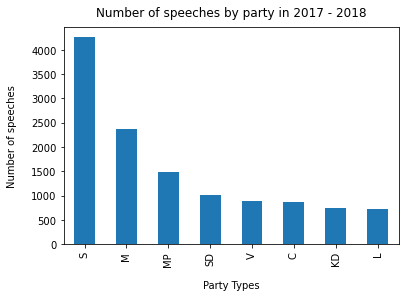

In [5]:
import matplotlib.pyplot as plt
training_data['party'].value_counts().plot(kind='bar');
plt.xlabel("Party Types", labelpad=14)
plt.ylabel("Number of speeches", labelpad=14)
plt.title("Number of speeches by party in 2017 - 2018", y=1.02);

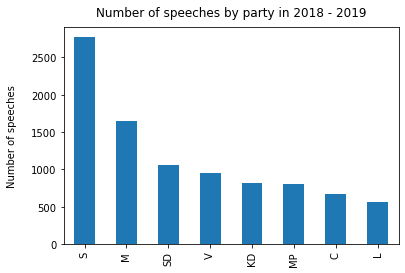

In [6]:
test_data['party'].value_counts().plot(kind='bar');
# plt.xlabel("Party Types", labelpad=14)
plt.ylabel("Number of speeches", labelpad=14)
plt.title("Number of speeches by party in 2018 - 2019", y=1.02);

*TODO: Enter your summary here*

The order of higher frequency is same but the middle order is different in both sets.

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

In [7]:
# TODO: Write code here to train and evaluate a Multinomial Naive Bayes classifier
from sklearn.model_selection import train_test_split
X_train = training_data['words']
X_test = test_data['words']
y_train = training_data['party']
y_test = test_data['party']

In [8]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB()

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
Vector = CountVectorizer()

In [10]:
pipeline = Pipeline([('vector',Vector),('Model',model1),])

In [11]:
Model = pipeline.fit(X_train,y_train)

In [12]:
y_pred = Model.predict(X_test)

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           C       0.04      0.63      0.07        41
          KD       0.02      0.70      0.03        20
           L       0.02      0.92      0.04        12
           M       0.68      0.36      0.47      3110
          MP       0.25      0.36      0.29       552
           S       0.84      0.46      0.59      5078
          SD       0.12      0.57      0.20       232
           V       0.15      0.59      0.24       243

    accuracy                           0.43      9288
   macro avg       0.26      0.57      0.24      9288
weighted avg       0.71      0.43      0.51      9288



Would you have expected the results that you got?

I expected the results because of the interpretations from the graph. The recall for party with low number of counts is higher but low precision. The precision score for party with large counts is higher and the same parties had low recall score. This problem is due to imbalance of the datasets. 

## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [14]:
# TODO: Write code here to evaluate the random baseline
from sklearn.dummy import DummyClassifier as DC

# Fitting the model
dummy_CLF = DC(strategy="stratified")
# Fitting the model
dummy_CLF.fit(X_train,y_train)

DummyClassifier(strategy='stratified')

In [15]:
# Predicting from model
dummy_CLF.predict(X_test)

# Model Score
dummy_CLF.score(X_test,y_test)

0.17743324720068906

An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [16]:
# TODO: Write code here to print the accuracy of the most frequent class baseline
# Fitting the model
dummy_CLF = DC(strategy="most_frequent")
# Fitting the model
dummy_CLF.fit(X_train,y_train)
# Predicting from model
y_pred = dummy_CLF.predict(X_test)

# Model Score
dummy_CLF.score(X_test,y_test)

0.298557278208441

## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Summarise your results in a short text.

**Hint:** Your balanced subset should consist of 5,752 speeches.

In [17]:
count = y_train.value_counts()

In [18]:
# TODO: Write code here to implement undersampling
# here since it is given as undersampling we should take the minimum count of each party and create data set based on that
new_data = pd.DataFrame()

In [19]:
for i in parties:
    df = training_data[training_data["party"] == i]
    df = df.sample(count.min())
    new_data = pd.concat([new_data,df])

In [20]:
X_train = new_data['words']
y_train = new_data['party']

Model = pipeline.fit(X_train,y_train)
y_pred = Model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           C       0.28      0.44      0.34       671
          KD       0.30      0.38      0.34       821
           L       0.27      0.43      0.33       560
           M       0.39      0.51      0.45      1644
          MP       0.37      0.34      0.35       809
           S       0.80      0.33      0.46      2773
          SD       0.45      0.40      0.42      1060
           V       0.40      0.55      0.46       950

    accuracy                           0.41      9288
   macro avg       0.41      0.42      0.39      9288
weighted avg       0.50      0.41      0.42      9288



In [21]:
# oversampling
new_data1 = pd.DataFrame()

In [22]:
for i in parties:
    df1 = training_data[training_data["party"] == i]
    df1 = df1.sample(count.max(),replace=True)
    new_data1= pd.concat([new_data1,df1])

In [23]:
X_train = new_data1['words']
y_train = new_data1['party']

Model = pipeline.fit(X_train,y_train)
y_pred = Model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           C       0.38      0.34      0.35       671
          KD       0.41      0.26      0.32       821
           L       0.29      0.31      0.30       560
           M       0.43      0.56      0.49      1644
          MP       0.32      0.48      0.39       809
           S       0.67      0.54      0.59      2773
          SD       0.45      0.44      0.45      1060
           V       0.46      0.45      0.45       950

    accuracy                           0.46      9288
   macro avg       0.43      0.42      0.42      9288
weighted avg       0.48      0.46      0.47      9288



*TODO: Enter the summary of your results here*  
The accuracy has increased in balanced data than unbalanced diet. The f1 score and prescision are more equal among different parties. 

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). If you would rather see a visual representation, you can also use [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

Your task is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.

In [24]:
# TODO: Write code here to solve Problem 5
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# here the confusion matrix is print
confusion_mat = confusion_matrix(y_test,y_pred,labels=parties)
print(confusion_mat)

[[ 225   32   28  142   72   93   46   33]
 [  49  214   45  217   74   93   73   56]
 [  36   28  173  102   55   63   54   49]
 [  96   70   91  923  116  167  123   58]
 [  29   30   39   87  392  150   40   42]
 [  80   68   92  339  354 1487  160  193]
 [  52   46   71  187   71   85  465   83]
 [  30   36   49  148   93   95   68  431]]


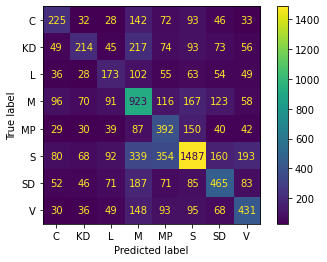

In [25]:
# Here confusion matrix is plotted
plot_confusion_matrix(Model,X_test,y_test)

Take a minute to reflect on whether your results make sense.

Parties C, KD, L, V, SD is confused by party M because their correlation is highest.  
Party M is confused by party S. 
Party S is confused by MP.

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words (binary) model in addition to the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting bigrams in addition to unigrams (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library. Print the results of your best model, along with the parameter values that yielded these results.

In [26]:
# TODO: Write code here to implement the grid search
from sklearn.model_selection import GridSearchCV
parameters = [{'vector__binary':(True, False),
              'vector__ngram_range':((1, 1),(1,2)),
             'Model__alpha':(1, 0.1)}]
Grid_Mu = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=5)

In [27]:
Grid_Mu.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vector', CountVectorizer()),
                                       ('Model', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'Model__alpha': (1, 0.1),
                          'vector__binary': (True, False),
                          'vector__ngram_range': ((1, 1), (1, 2))}])

In [28]:
Grid_Mu.best_params_

{'Model__alpha': 0.1, 'vector__binary': True, 'vector__ngram_range': (1, 2)}

In [29]:
y_pred = Grid_Mu.predict(X_test)

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           C       0.60      0.10      0.18       671
          KD       0.61      0.07      0.13       821
           L       0.43      0.06      0.11       560
           M       0.36      0.71      0.48      1644
          MP       0.39      0.34      0.36       809
           S       0.50      0.79      0.61      2773
          SD       0.64      0.21      0.32      1060
           V       0.64      0.22      0.33       950

    accuracy                           0.46      9288
   macro avg       0.52      0.31      0.32      9288
weighted avg       0.51      0.46      0.40      9288



## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model.

In [31]:
# TODO: Write code here to search for a better model and print the results
from sklearn.linear_model import SGDClassifier, LogisticRegression

pipeline = Pipeline([('Vector',CountVectorizer()),
                     ('tfidf',TfidfTransformer()),
               ('Model',LogisticRegression()),])


In [32]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Vector', 'tfidf', 'Model', 'Vector__analyzer', 'Vector__binary', 'Vector__decode_error', 'Vector__dtype', 'Vector__encoding', 'Vector__input', 'Vector__lowercase', 'Vector__max_df', 'Vector__max_features', 'Vector__min_df', 'Vector__ngram_range', 'Vector__preprocessor', 'Vector__stop_words', 'Vector__strip_accents', 'Vector__token_pattern', 'Vector__tokenizer', 'Vector__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'Model__C', 'Model__class_weight', 'Model__dual', 'Model__fit_intercept', 'Model__intercept_scaling', 'Model__l1_ratio', 'Model__max_iter', 'Model__multi_class', 'Model__n_jobs', 'Model__penalty', 'Model__random_state', 'Model__solver', 'Model__tol', 'Model__verbose', 'Model__warm_start'])

In [33]:
parameters = [{'Vector__binary':(True, False),
              'Vector__ngram_range':((1, 1),(1,2)),
               'tfidf__norm':('l1','l2'),
             'Model__penalty':('l1','l2'),
              'Model__solver':['liblinear']}]

Grid = GridSearchCV(pipeline,parameters,n_jobs=-1,cv=5)

In [34]:
Grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Vector', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('Model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'Model__penalty': ('l1', 'l2'),
                          'Model__solver': ['liblinear'],
                          'Vector__binary': (True, False),
                          'Vector__ngram_range': ((1, 1), (1, 2)),
                          'tfidf__norm': ('l1', 'l2')}])

In [35]:
y_pred = Grid.predict(X_test)

In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           C       0.52      0.39      0.44       671
          KD       0.51      0.30      0.38       821
           L       0.48      0.36      0.41       560
           M       0.49      0.57      0.53      1644
          MP       0.35      0.48      0.41       809
           S       0.64      0.67      0.65      2773
          SD       0.52      0.55      0.54      1060
           V       0.58      0.51      0.54       950

    accuracy                           0.54      9288
   macro avg       0.51      0.48      0.49      9288
weighted avg       0.54      0.54      0.53      9288



## Reflection questions

The following reflection questions are questions that you could be asked in the oral exam. Try to answer each of them in the form of a short text and enter it in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 2.1:** Summarise the results of your experiments for Problem&nbsp;2. Are your results ‘good’ or ‘bad’? How do you determine that?  



The precision and f1 score low for many parties. So, we could consider it is bad. This is determined by that we dont want a classifier that have bad performance on some classes.

However, if we simply want a model which has best performance respecting class prior, this result could be viewed good.



**RQ 2.2:** Summarise the results of your experiments for Problem&nbsp;4. Would you think that your results are typical even for other classification tasks? How would *oversampling* have looked like for this task? When would you use undersampling, when oversampling?  



1.

No, undersampling will discard data, which might make it harder to learn the decision boundary between majority instances and minority instances.This is extreamlly critical for models that are sensitive to data on decistion boundary.



2.

Oversampling will randomlly copy instances in minority classes so that the sizes of different classes are the same. In this procedure, bias might be introduced. And it will also increase the probability of overfitting. It will also notably increase the size of training data, respecting the number of minority classes and the size of majority classes, which might be a big problem for the models scaled quickly on data size.  



3.

For cases that the decision boundary is not critical, or the data size is much larger than needed, undersampling is a good choice.



For cases that data scale is not important and introduced bias is affordable, oversampling will be better choice.



There are some methods combining oversampling and undersampling, which could leverage both.



**RQ 2.3:** Which model performed best in your experiments for Problem&nbsp;6? Why is it important to do a hyperparameter search before drawing conclusions about the performance of a model? Why is it often not done, anyway? Why should you never tune hyperparameters on the test set?  



1.



In vectorizer, using a set-of-words (binary) model and extracting bigrams.

In the Naive Bayes classifier, using additive smoothing alpha = 0.1



2.



Different hyperparameters means different models.According to No Free Lunch law, the hyperparameters should not influence the performance of the model on all possible data.



However, different models will have different peformance on certain dataset. Tuning hyperparameters is the procedure which we select the best model given a dataset and its corresponding distribution.



3.



Tuning hyperparameters might lead to overfitting. When we choose the best model for training data, we have no idea how much noise the model learns from it. Learning too much noise will lead to that the model performs badly on new data, which is low generalization ability. 



Regularization is a way to reduce generalization error .However, there is no common regularization method for all models.



Testing on validation is a way to evaluate generalization ability, which can reduce the risk of overfitting. However, if we divide some data from training set as validation, the new training set size will be smaller, which will lead to estimation error.



Tuning hyperparameters is also time consuming. If the hyperparameters size are too larger than the times of training we can afford, it is a important problem to choose proper searching algorithm. And sometimes it is even impossible.  

   

Another case are that hyperparameters themselves should not be tuned. For example, when we train a regression model, if we set the degree of the fitted function as hyperparameter, then we will only increase the degree to fit training data perfectly, and get a extremelly complex model. This can be avoided by regularizatoin.  



So, in many cases, tuning hyperparameter is not a easy choice.

 

4.



If we tune hyperparameters on the test set, the model will learn the distribution of test set, and the best selected model will also learn it. In this case, performance on test set cannot be viewed as generalization ability.

*TODO: Enter your answers here*

**Congratulations on finishing L2! 👍**